# Breast Cancer Classification And Biomarker Discovery

Giordano Scerra

Lorea Erekatxo

---
## Generate the Dataset

In [35]:
import pandas as pd

# File paths
fpkm_file = "GSE183947_fpkm.csv"  # Path to the FPKM data file
metadata_file = "GSE183947_series_matrix.txt"  # Path to the metadata file

# Step 1: Load FPKM data
print("Loading FPKM data...")
fpkm_data = pd.read_csv(fpkm_file)  # Load FPKM data into a DataFrame
fpkm_data = fpkm_data.rename(columns=lambda x: x.strip())  # Clean column names by removing extra spaces
print(f"FPKM data loaded. Shape: {fpkm_data.shape}") # Output the shape of the FPKM data

# Step 2: Extract Metadata
print("Extracting metadata...")
metadata_dict = {}
with open(metadata_file, "r") as f:
    for line in f: # Iterate through lines in the metadata file
        # Select lines of interest based on their prefix
        if line.startswith("!Sample_title") or line.startswith("!Sample_characteristics_ch1"):
            # Split the line into key and values
            key, *values = line.strip().split("\t")
            metadata_dict[key] = values # Add to the metadata dictionary

# Convert metadata into a DataFrame
metadata = pd.DataFrame(metadata_dict).T  # Transpose for correct structure
metadata.columns = metadata.iloc[0]  # Set first row as header
metadata = metadata[1:]  # Remove the header row from the data
metadata.reset_index(inplace=True, drop=True)  # Reset index for consistency
metadata = metadata.rename(columns=lambda x: x.strip())  # Clean column names by stripping spaces
metadata.columns.name = None  # Remove the name of the column index

# Clean and adjust metadata sample titles
metadata.columns = [col.replace('"', '').strip() for col in metadata.columns] # Remove extra quotes and spaces

# Step 3: Create a mapping between metadata and FPKM columns
# Assuming the FPKM file and metadata samples are aligned in order
fpkm_samples = fpkm_data.columns[1:]  # Exclude 'GeneID' column and get FPKM sample column names
metadata_samples = metadata.columns  # Get metadata sample titles
mapping = dict(zip(metadata_samples, fpkm_samples))  # Create a dictionary to map metadata to FPKM samples

# Step 4: Merge Data
print("Merging metadata with FPKM data...")
# Transpose FPKM data: Samples become rows, genes become columns
fpkm_data_t = fpkm_data.set_index("Unnamed: 0").T.reset_index()  # Transpose FPKM data and reset the index
fpkm_data_t.rename(columns={"index": "Sample_title"}, inplace=True) # Rename the index column to "Sample_title"

# Map FPKM sample names to metadata sample names
fpkm_data_t["Sample_title"] = fpkm_data_t["Sample_title"].map({v: k for k, v in mapping.items()})

# Merge metadata and FPKM data based on "Sample_title"
merged_data = pd.merge(metadata.T, fpkm_data_t, left_index=True, right_on="Sample_title")

# Step 5: Save the merged data
output_file = "merged_GSE183947.csv"
merged_data.to_csv(output_file, index=False) # Save the merged DataFrame to a CSV file
print(f"Merged data saved to {output_file}. Shape: {merged_data.shape}") # Output the shape of the merged data
merged_data.head() ## Display the first few rows of the merged data


Loading FPKM data...
FPKM data loaded. Shape: (20246, 61)
Extracting metadata...
Merging metadata with FPKM data...
Merged data saved to merged_GSE183947.csv. Shape: (60, 20248)


,0,Sample_title,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,CTB-96E2.2,CTC-432M15.3,RP11-986E7.7,RP11-761B3.1,ZBTB8B,RP11-1084J3.4,RP11-944L7.5,FLJ00388,RP11-474G23.1,AC005358.1
0,"""donor: 102548""",tumor rep1,0.93,0.0,0.00,5.78,2.83,4.80,1.37,21.92,...,0.0,0.0,0.00,0.00,38.27,0.00,0.0,0.00,0.00,0.0
1,"""donor: 104338""",tumor rep2,1.97,0.0,0.43,5.17,6.26,1.83,1.78,10.48,...,0.0,0.0,0.10,0.03,30.99,0.16,0.0,0.00,0.00,0.0
2,"""donor: 105094""",tumor rep3,0.00,0.0,0.00,8.76,3.37,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,47.57,0.00,0.0,0.00,0.00,0.0
3,"""donor: 109745""",tumor rep4,5.45,0.0,3.43,4.58,6.24,4.23,2.59,23.78,...,0.0,0.0,1.15,0.00,12.27,0.00,0.0,0.83,0.10,0.0
4,"""donor: 1906415""",tumor rep5,4.52,0.0,8.45,7.20,5.16,15.87,9.21,14.95,...,0.0,0.0,0.00,0.00,4.69,0.00,0.0,0.00,0.64,0.0


## Choose hyperparameters for the analysis

In [36]:
p_values_threshold = 0.01
features_kind = "significant_genes"
n_estimators = 100
kernel= "linear"

## Feature Selection

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Differential Expression Analysis
# Assuming 'merged_data' has a column 'Sample_title' indicating 'Tumor' or 'Normal'
# Filter out tumor and normal samples based on the 'Sample_title' column
tumor_samples = merged_data[merged_data['Sample_title'].str.contains('tumor', case=False)]
normal_samples = merged_data[merged_data['Sample_title'].str.contains('normal', case=False)]

# Print the count of tumor and normal samples for verification
print(f"Tumor samples: {tumor_samples.shape[0]}")
print(f"Normal samples: {normal_samples.shape[0]}")

# Perform t-test for each gene gene to compare expression levels between tumor and normal samples
p_values = []
for gene in merged_data.columns[2:]:  # Iterate over gene columns (exclude metadata columns like 'Sample_title')
    tumor_values = tumor_samples[gene].astype(float) # Get expression values for the tumor group
    normal_values = normal_samples[gene].astype(float) # Get expression values for the normal group
    t_stat, p_val, _ = sm.stats.ttest_ind(tumor_values, normal_values) # Perform two-sample t-test
    p_values.append(p_val) # Collect p-values

# Adjust p-values for multiple testing using Benjamini-Hochberg method
# Filter out invalid values (NaNs or infinite p-values) before adjustment
p_values = np.array(p_values)  # Convert list to numpy array for numerical operations
finite_mask = np.isfinite(p_values)  # Identify finite (valid) p-values
p_values = p_values[finite_mask]  # Retain only valid p-values

# Perform multiple testing correction using the False Discovery Rate (FDR) method
_, p_adj, _, _ = sm.stats.multipletests(p_values, method='fdr_bh')  # Adjust p-values using Benjamini-Hochberg

# Biomarker Discovery
# Select genes with significant adjusted p-values (threshold: < 0.01)
genes_tested = merged_data.columns[2:][finite_mask]  # Ensure only genes corresponding to valid p-values are considered
significant_genes = genes_tested[p_adj < p_values_threshold]  # Select genes with adjusted p-value < 0.01

# Use the rest of the features (excluding significant_genes) for classification
non_significant_genes = genes_tested[~genes_tested.isin(significant_genes)]

#'Sample_title' as labels
y = merged_data['Sample_title'].apply(lambda x: 1 if 'tumor' in x.lower() else 0)  # Encode Tumor as 1, Normal as 0
merged_data = merged_data.drop(columns=['Sample_title'])  # Drop 'Sample_title' column

Tumor samples: 30
Normal samples: 30


C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\sta

## Training and Test set generation

In [38]:
if features_kind == 'significant_genes':
    mask = significant_genes
else:
    mask = non_significant_genes
# Use non-significant genes as features
X = merged_data[mask].astype(float)  # Extract non-significant genes' expression levels as feature matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the training and testing datasets for verification
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Print the percentage of significant genes
print(f"Significant genes percentage: {significant_genes.shape[0]/len(p_values)*100:.2f}%")

Training set shape: (42, 2742)
Testing set shape: (18, 2742)
Significant genes percentage: 13.64%


## Random Forest + Top Candidate Biomarkers

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



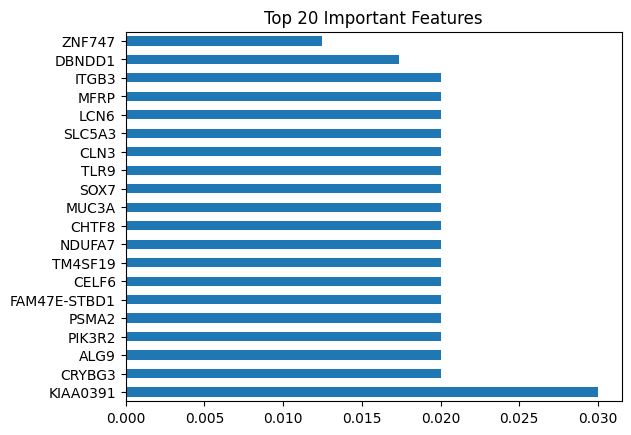

In [39]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42) # Initialize the model with 100 trees
clf.fit(X_train, y_train) # Train the model using the training data

# Predict and evaluate the model
y_pred = clf.predict(X_test) # Predict labels for the test set
print(classification_report(y_test, y_pred)) # Print a classification report (precision, recall, F1-score)


# Plot the importance of the top 20 features (genes) identified by the classifier
feature_importances = pd.Series(clf.feature_importances_, index=mask) # Extract feature importance scores
feature_importances.nlargest(20).plot(kind='barh') # Plot the top 20 important features
plt.title("Top 20 Important Features") # Add a title to the plot
plt.show() # Display the plot

## PCA study

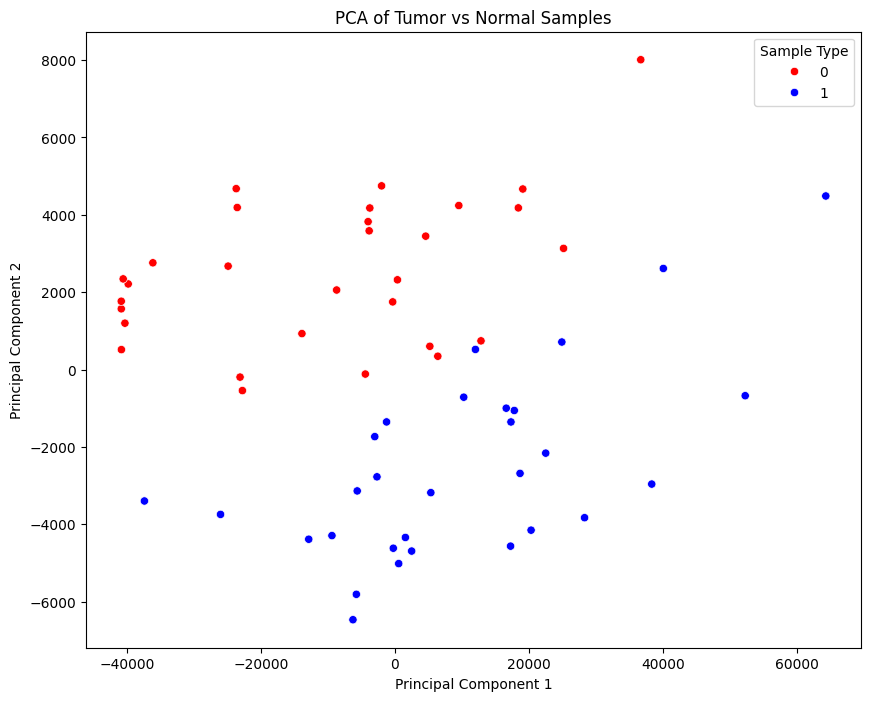

In [40]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Sample_type'] = y.values

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Sample_type', data=pca_df, palette=['red', 'blue'])
plt.title('PCA of Tumor vs Normal Samples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sample Type')
plt.show()

## Support Vector Machine + Top Candidate Biomarkers

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



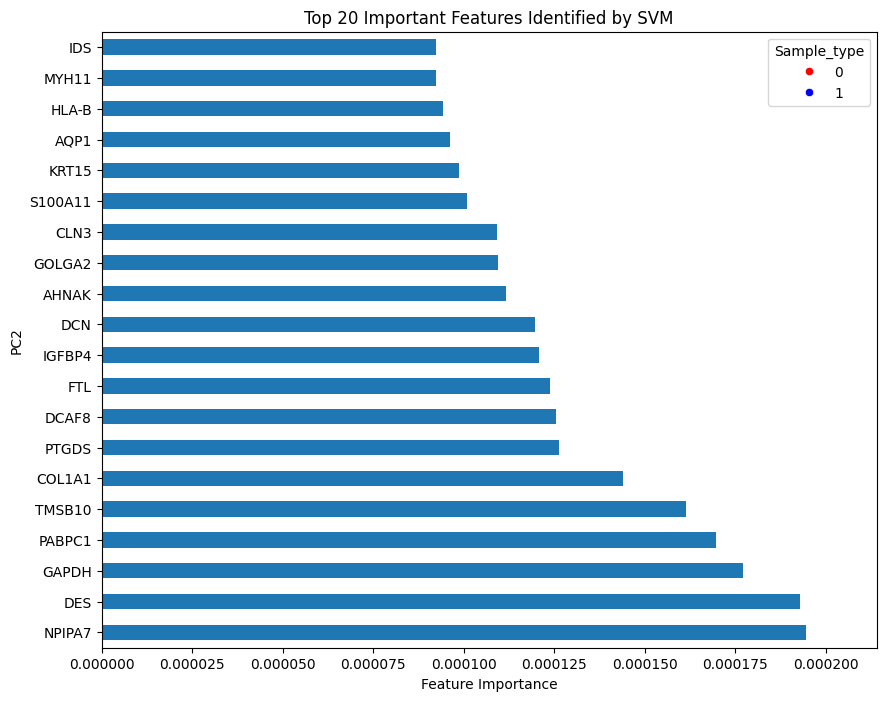

In [41]:
from sklearn.svm import SVC
# Train a Support Vector Machine (SVM) classifier
svm_clf = SVC(kernel=kernel, random_state=42)
svm_clf.fit(X_train, y_train)

# Predict and evaluate the SVM model
y_pred_svm = svm_clf.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot SVM decision boundary using PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Sample_type', data=pca_df, palette=['red', 'blue'])

# Find the most important features for the discriminative task
svm_coef = np.abs(svm_clf.coef_).flatten()  # Get the absolute values of the SVM coefficients
important_features = pd.Series(svm_coef, index=mask).nlargest(20)  # Get the top 20 important features

# Plot the top 20 important features without scaling
important_features.plot(kind='barh')
plt.title("Top 20 Important Features Identified by SVM")
plt.xlabel("Feature Importance")
plt.xlim(0, important_features.max() * 1.1)  # Adjust the x-axis limits based on the feature importance limits
plt.show()


## RECAP RF + UP/DOWN REGULATION STUDY

In [42]:
# Recap Random Forest results
rf_f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
top_rf_features = feature_importances.nlargest(5)

# Determine if the top features are upregulated or downregulated
rf_regulation = []
for gene in top_rf_features.index:
    tumor_mean = tumor_samples[gene].mean()
    normal_mean = normal_samples[gene].mean()
    
    # Statistical significance
    t_stat, p_value, _ = sm.stats.ttest_ind(tumor_samples[gene], normal_samples[gene])
    
    # Fold change
    log2_fc = np.log2(tumor_mean / normal_mean) if normal_mean != 0 else float('inf')
    
    # Determine regulation
    if p_value < 0.01:
        if log2_fc > 1:
            regulation = "upregulated"
        elif log2_fc < -1:
            regulation = "downregulated"
        else:
            regulation = "no significant change"
    else:
        regulation = "no significant change"
    
    rf_regulation.append(regulation)

# Create a DataFrame for Random Forest results
rf_results = pd.DataFrame({
    'Feature': top_rf_features.index,
    'Regulation': rf_regulation
})

# Recap SVM results
svm_f1_score = classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']['f1-score']
top_svm_features = important_features.nlargest(5)

# Determine if the top features are upregulated or downregulated
svm_regulation = []
for gene in top_svm_features.index:
    tumor_mean = tumor_samples[gene].mean()
    normal_mean = normal_samples[gene].mean()
    
    # Statistical significance
    tstat, p_value, _ = sm.stats.ttest_ind(tumor_samples[gene], normal_samples[gene])
    
    # Fold change
    log2_fc = np.log2(tumor_mean / normal_mean) if normal_mean != 0 else float('inf')
    
    # Determine regulation
    if p_value < 0.01:
        if log2_fc > 1:
            regulation = "upregulated"
        elif log2_fc < -1:
            regulation = "downregulated"
        else:
            regulation = "no significant change"
    else:
        regulation = "no significant change"
    
    svm_regulation.append(regulation)

# Create a DataFrame for SVM results
svm_results = pd.DataFrame({
    'Feature': top_svm_features.index,
    'Regulation': svm_regulation
})

# Display the results
print("Random Forest Weighted Average F1 score:")
print(rf_f1_score)
print("\nTop 3 Important Features (Random Forest):")
rf_results.head()

Random Forest Weighted Average F1 score:
1.0

Top 3 Important Features (Random Forest):


,Feature,Regulation
0,KIAA0391,downregulated
1,CRYBG3,downregulated
2,ALG9,downregulated
3,PIK3R2,downregulated
4,PSMA2,downregulated


## RECAP SVM + UP/DOWN REGULATION STUDY

In [43]:
print("\nSVM Weighted Average F1 score:")
print(svm_f1_score)
print("\nTop 3 Important Features (SVM):")
svm_results.head()


SVM Weighted Average F1 score:
1.0

Top 3 Important Features (SVM):


,Feature,Regulation
0,NPIPA7,downregulated
1,DES,downregulated
2,GAPDH,upregulated
3,PABPC1,no significant change
4,TMSB10,upregulated
